In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.filters import cf_filter
dir = os.getcwd()

In [184]:
#### 파이프라인
#1. 샘플기간 PCA 후 성장지표 산정

#2. 테스트기간 한 시점 추가될 때 마다 PCA 새로 진행 + 성장지표 새로 산정

#3. new 성장지표 시계열로 CF 필터 적용

#4. 국면 판단 진행: 결과 저장

#-> 이 과정 쭉 반복

In [185]:
from google.colab import files
uploaded = files.upload()  # merged.csv 선택

import pandas as pd
import io

# merged.csv가 있으면 그걸, 없으면 업로드한 첫 파일 사용
fname = 'merged.csv' if 'merged.csv' in uploaded else next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[fname]))

# 확인
df.head()

Saving merged.csv to merged (2).csv


,date,bsi_inv_big,bsi_inv_small,3y,10y,shipment,inven,ipi,employ,durable,wti,dubai,iron,copper,gold
0,1975-01-01,NaN,NaN,NaN,NaN,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1975-02-01,NaN,NaN,NaN,NaN,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1975-03-01,NaN,NaN,NaN,NaN,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1975-04-01,NaN,NaN,NaN,NaN,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1975-05-01,NaN,NaN,NaN,NaN,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [186]:
df = pd.read_csv("merged.csv")

#날짜를 인덱스로 설정
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)
df1 = df.copy().dropna() #결측치 제거

#문자로 된 자료 숫자로 바꿔주기
for a in df1.columns:
    df1[a] = df1[a].astype('float')


#장단기 스프레드 // 출하지수-재고지수 스프레드
df1['y_spd'] = df1['10y'] - df1['3y']
df1['manu_spd'] = df1['shipment'] - df1['inven']
df1['manu_ratio'] = (df1['shipment'] / df1['inven']) #스프레드하면 스케일이 약간 애매해져서, 양 지수에 로그취해서 빼줌

#설비투자전망지수 대기업+중소기업 평균 산출
df1['bsi_inv'] = (df1['bsi_inv_big'] + df1['bsi_inv_small']) / 2

#필요없는거 제거
df2 = df1.drop(columns=['bsi_inv_big', 'bsi_inv_small','10y', '3y', 'shipment', 'inven',
                        'wti','iron', 'copper', 'gold'])

#로그 씌우기
list_log = ['employ', 'durable', 'dubai', 'bsi_inv','manu_ratio']
for a in list_log:
    df2[a+'_l'] = np.log(df2[a])

In [187]:
df2[['y_spd', 'manu_ratio_l', 'bsi_inv_l', 'employ_l', 'durable_l', 'dubai_l']].to_csv('log_merged.csv')

In [188]:
df2 = df2[['y_spd', 'manu_ratio_l', 'bsi_inv_l', 'employ_l', 'durable_l', 'dubai_l']]

df2_train = df2['2003-02-01':'2017-06-01']
df2_test = df2['2017-07-01':]

In [189]:
#PCA 함수
def pca(x):
    '''
    데이터프레임을 인풋으로
    PCA 결과들을 딕셔너리에 모아서 리턴해줌
    딕셔너리 키 목록
    1. df_scaled: 표준화된 데이터
    2. cov_matrix: 표준화된 데이터의 공분산 행렬
    3. eigenvalues_df: eigenvalues
    4. eigenvectors_df: eigenvectors
    5. explained_variance_ratio_df: 분산 설명비율
    '''
    scaler = StandardScaler() # standard normal
    df_scaled = scaler.fit_transform(x) #데이터 표준화
    cov_matrix = np.cov(df_scaled, rowvar=False) #공분산 행렬 계산

 ## 요부분 수정함
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)   # 대칭 행렬용, 안정적
    idx = np.argsort(eigenvalues)[::-1]  # 큰 값 순 정렬
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # PC1 방향을 나타내는 벡터
    pc1_vector = eigenvectors[:, 0]

    #Explained Variance Ratio
    explained_variance_ratio = eigenvalues / np.sum(eigenvalues)

    #PCA 결과 저장
    index = []
    for i in range(0,len(x.columns)):
        index.append(f'PC{i+1}')

    cov_matrix_df = pd.DataFrame(cov_matrix, columns=x.columns, index=x.columns)
    eigenvalues_df = pd.DataFrame({'Eigenvalues': eigenvalues}, index=index)
    eigenvectors_df = pd.DataFrame(eigenvectors, columns=index,
                                index=x.columns)
    explained_variance_ratio_df = pd.DataFrame({'Explained Variance Ratio': explained_variance_ratio},
                                            index=index)
    result = {'df_scaled' : df_scaled,
              'cov_matrix' : cov_matrix,
              'eigenvalues' : eigenvalues_df,
              'eigenvectors' : eigenvectors_df,
              'explained_variance' : explained_variance_ratio_df}
    print(result.keys())
    return result

In [190]:
CF_LOW, CF_HIGH = 18, 96
CF_DRIFT = True  # 랜덤워크+드리프트 가정

def cf_cycle(series, low=CF_LOW, high=CF_HIGH, drift=CF_DRIFT):
    s = pd.to_numeric(series, errors='coerce')
    cyc, _trend = cf_filter.cffilter(s, low=low, high=high, drift=drift)
    return pd.Series(cyc, index=s.index, name=series.name)

def zscore(series):
    mu, sd = series.mean(), series.std(ddof=0)
    return (series - mu) / sd

In [191]:
# === 블록13: 2연속 규칙 기반 실시간 극점 탐지(룩어헤드 無, 수정판) ===
# 이상치 탐지 함수
def detect_extrema_rule2(series: pd.Series,
                         halflife: float = 0.0,   # 0이면 스무딩 없음
                         min_gap: int = 4,        # 극점 간 최소 간격(개월)
                         prom_k: float = 0.0,     # 프로미넌스: 과거 σ의 k배 이상만 채택(0이면 미적용)
                         roll_std_win: int = 60,  # σ 계산 창
                         deadband_k: float = 0.0, # 변화가 너무 미세하면 0으로 취급(Δ의 σ 대비 k배)
                         deadband_win: int = 24):
    """
    피크 at t   : Δ_{t-2} > 0  and Δ_{t-1} < 0 and Δ_{t} < 0
    트로프 at t : Δ_{t-2} < 0  and Δ_{t-1} > 0 and Δ_{t} > 0
    확정 시점은 t (두 번째 감소/증가가 관측된 달). 미래 정보 사용 없음.
    """
    x = series.ewm(halflife=halflife, adjust=False).mean() if (halflife and halflife > 0) else series.copy()

    d = x.diff()

    # 데드밴드: Δ의 롤링 표준편차 기반 임계값
    if deadband_k > 0:
        d_std = d.rolling(deadband_win, min_periods=max(4, deadband_win//3)).std()
        thr = deadband_k * d_std
        # 부호 결정
        sign = np.where(d > thr,  1, np.where(d < -thr, -1, 0))
    else:
        sign = np.sign(d.values)

    sign = pd.Series(sign, index=d.index)

    # 프로미넌스 계산용 과거 σ
    roll_std = x.rolling(roll_std_win, min_periods=max(6, roll_std_win//3)).std()

    events = []
    last_idx = -10_000
    last_peak_level = None
    last_trough_level = None

    for i in range(2, len(x)):
        # 최소 간격
        if i - last_idx < min_gap:
            continue

        s2 = sign.iloc[i-2]  # Δ_{t-2}
        s1 = sign.iloc[i-1]  # Δ_{t-1}
        s0 = sign.iloc[i]    # Δ_{t}

        is_peak   = (s2 > 0) and (s1 < 0) and (s0 < 0)
        is_trough = (s2 < 0) and (s1 > 0) and (s0 > 0)
        if not (is_peak or is_trough):
            continue

        # 프로미넌스 필터
        if prom_k > 0:
            sigma_t = float(roll_std.iloc[:i].iloc[-1]) if not roll_std.iloc[:i].empty else float(x.std())
            sigma_t = sigma_t if sigma_t > 0 else float(x.std())
            if is_peak and (last_trough_level is not None):
                if (x.iloc[i] - last_trough_level) < prom_k * sigma_t:
                    continue
            if is_trough and (last_peak_level is not None):
                if (last_peak_level - x.iloc[i]) < prom_k * sigma_t:
                    continue

        ev_type = "peak" if is_peak else "trough"
        events.append({"date": x.index[i], "type": ev_type, "level": float(x.iloc[i])})
        last_idx = i
        if is_peak:
            last_peak_level = float(x.iloc[i])
        else:
            last_trough_level = float(x.iloc[i])

    events_df = pd.DataFrame(events).set_index("date") if events else pd.DataFrame(columns=["type","level"])
    out = {
        "series_used": x,
        "diff": d,
        "events_df": events_df
    }
    return out

In [210]:
cf_cycle_series = cf_filter.cffilter(df2_test, low=18, high=96, drift=True)[0]

In [211]:
cf_cycle_series

,y_spd_cycle,manu_ratio_l_cycle,bsi_inv_l_cycle,employ_l_cycle,durable_l_cycle,dubai_l_cycle
date,,,,,,
2017-07-01,0.001600,0.011111,0.010430,0.005078,-0.008805,0.005758
2017-08-01,-0.000155,0.011020,0.014004,0.005590,-0.006775,0.040110
2017-09-01,-0.000796,0.009925,0.017195,0.005981,-0.004410,0.076190
2017-10-01,-0.000558,0.007766,0.019622,0.006214,-0.001898,0.112097
2017-11-01,0.000160,0.004586,0.020964,0.006260,0.000552,0.145986
...,...,...,...,...,...,...
2025-02-01,-0.003843,0.009614,-0.015983,-0.001472,-0.010279,-0.098007
2025-03-01,0.024009,0.015164,-0.019124,-0.001714,-0.007621,-0.113026
2025-04-01,0.050828,0.021257,-0.020771,-0.001918,-0.005634,-0.122883


In [194]:
dates_detected = []
types_detected = []


for i in range(0,len(df2_test.index)):
    time = df2_test.index[i] # 예측값 얻고 싶은 날짜
    temp = df2['2003-02-01':time] # 데이터셋 이름 바뀌면 이 부분 수정


    #PCA 진행
    pca_result = pca(temp)

    #pca1의 주성분을 PC1, PC2, PC3로 설정
    #표준화된 X 랑 eigenvector 곱하기
    data_pc = pca_result['df_scaled']@pca_result['eigenvectors'][['PC1', 'PC2', 'PC3']]
    data_pc.index = temp.index
    # Growth indicator 산출하는 부분
    # 각 지표별 가중치 변경하려면 이 부분 수정하기
    w0 = pca_result['explained_variance']['Explained Variance Ratio'].iloc[0]
    w1 = pca_result['explained_variance']['Explained Variance Ratio'].iloc[1]
    w2 = pca_result['explained_variance']['Explained Variance Ratio'].iloc[2]

    data_pc['growth_indicator'] = data_pc['PC1']*w0/(w0+w1+w2) + data_pc['PC2']*w1/(w0+w1+w2) + data_pc['PC3']*w2/(w0+w1+w2)

    #cf필터 적용
    data_pc['cf'] = cf_filter.cffilter(data_pc['growth_indicator'], low=18, high=96, drift=True)[0]

    regime_result = detect_extrema_rule2(data_pc['cf']) #국면 전환점 탐지

    regime_result['events_df'].index = pd.to_datetime(regime_result['events_df'].index) # events_df 의 인덱스 설정

    # t, t-1, t-2 중에 이상치 탐지된거 있나 확인
    target_dates = [time, time + pd.DateOffset(months=-1), time + pd.DateOffset(months=-2)]
    for a in target_dates:
        if a in regime_result['events_df'].index:
            date = pd.to_datetime(a)
            dates_detected.append(date)
            types_detected.append(regime_result['events_df']['type'].loc[a])
            # types_detected.append(regime_result['events_df'])



dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_

In [212]:
dates_detected

[Timestamp('2017-07-01 00:00:00'),
 Timestamp('2017-07-01 00:00:00'),
 Timestamp('2018-04-01 00:00:00'),
 Timestamp('2018-05-01 00:00:00'),
 Timestamp('2018-05-01 00:00:00'),
 Timestamp('2018-10-01 00:00:00'),
 Timestamp('2019-09-01 00:00:00'),
 Timestamp('2019-09-01 00:00:00'),
 Timestamp('2019-10-01 00:00:00'),
 Timestamp('2019-11-01 00:00:00'),
 Timestamp('2021-02-01 00:00:00'),
 Timestamp('2021-01-01 00:00:00'),
 Timestamp('2022-11-01 00:00:00'),
 Timestamp('2022-11-01 00:00:00'),
 Timestamp('2022-11-01 00:00:00')]

In [213]:
types_detected

['trough',
 'trough',
 'peak',
 'peak',
 'peak',
 'trough',
 'peak',
 'peak',
 'peak',
 'peak',
 'trough',
 'trough',
 'peak',
 'peak',
 'peak']

In [214]:
#국면 전환 판단된 날짜랑 국면 타입을 데이터프레임으로 만들기
detection_result = pd.DataFrame({'date': dates_detected, 'type': types_detected})

In [215]:
#중복제거
detection_result = detection_result.drop_duplicates('date')

In [216]:
#인덱스 설정
detection_result.set_index('date', inplace=True)

In [217]:
detection_result

,type
date,
2017-07-01,trough
2018-04-01,peak
2018-05-01,peak
2018-10-01,trough
2019-09-01,peak
2019-10-01,peak
2019-11-01,peak
2021-02-01,trough
2021-01-01,trough


In [218]:
# 연속된 같은 type 값 제거 (첫 번째만 남김)
filtered = detection_result[detection_result['type'] != detection_result['type'].shift()]

print(filtered)

              type
date              
2017-07-01  trough
2018-04-01    peak
2018-10-01  trough
2019-09-01    peak
2021-02-01  trough
2022-11-01    peak


In [219]:
data_pc['cf']

,cf
date,
2003-02-01,-0.030703
2003-03-01,-0.084119
2003-04-01,-0.139134
2003-05-01,-0.194448
2003-06-01,-0.248657
...,...
2025-02-01,-0.172926
2025-03-01,-0.225091
2025-04-01,-0.272668


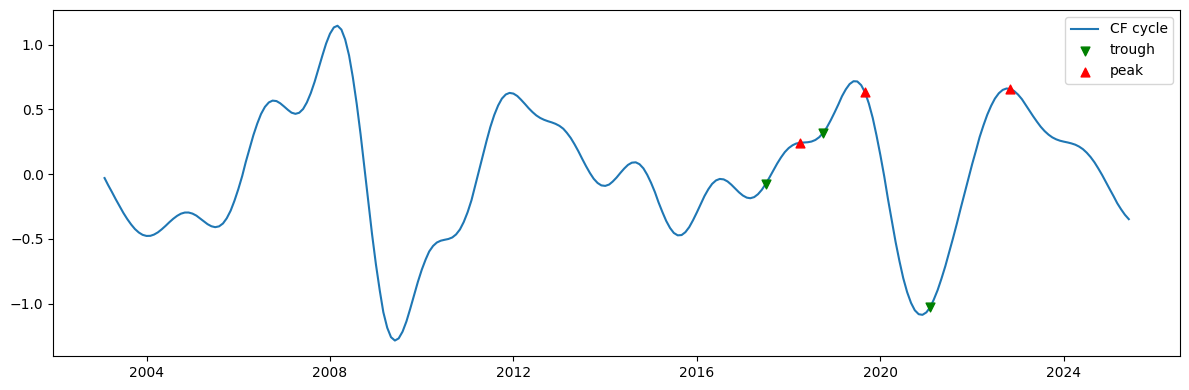

In [220]:
# 베이스 플롯
plt.figure(figsize=(12,4))
plt.plot(data_pc['cf'], label='CF cycle')

# filtered에서 peak/trough 분리
peak_idx   = filtered.index[filtered['type'] == 'peak']
trough_idx = filtered.index[filtered['type'] == 'trough']

# 점 찍기
plt.scatter(trough_idx, data_pc['cf'].loc[trough_idx], s=40, marker='v', color='green', label='trough', zorder=3)
plt.scatter(peak_idx,   data_pc['cf'].loc[peak_idx],   s=40, marker='^', color='red',   label='peak',   zorder=3)

plt.legend()
plt.tight_layout()
plt.show()

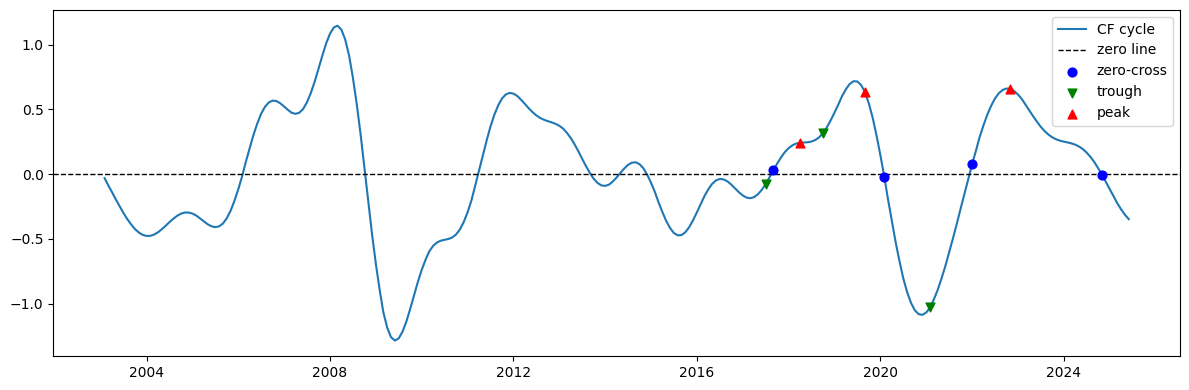

In [222]:
# 베이스 플롯
plt.figure(figsize=(12,4))
plt.plot(data_pc['cf'], label='CF cycle')

# 0 기준선
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='zero line')

# zero-cross 시점 (2017-07 이후만)
zero_cross = data_pc['cf'][
    (data_pc['cf'].shift(1) * data_pc['cf'] < 0) &
    (data_pc.index >= '2017-07-01')
].index

# 점 찍기 (zero-cross)
plt.scatter(zero_cross, data_pc['cf'].loc[zero_cross],
            s=40, marker='o', color='blue', label='zero-cross', zorder=3)

# filtered에서 peak/trough 분리
peak_idx   = filtered.index[filtered['type'] == 'peak']
trough_idx = filtered.index[filtered['type'] == 'trough']

# 점 찍기 (peak/trough)
plt.scatter(trough_idx, data_pc['cf'].loc[trough_idx],
            s=40, marker='v', color='green', label='trough', zorder=3)
plt.scatter(peak_idx,   data_pc['cf'].loc[peak_idx],
            s=40, marker='^', color='red',   label='peak',   zorder=3)

plt.legend()
plt.tight_layout()
plt.show()

In [223]:
# =========================
# 1) zero-cross, peak/trough 시점 출력 (2017-07-01 이후)
# =========================
cf = data_pc['cf'].dropna()

# zero-cross: 부호 변화가 발생한 시점(t) 추출
zero_cross_idx = cf[(cf.shift(1) * cf < 0)].index
zero_cross_idx = zero_cross_idx[zero_cross_idx >= pd.Timestamp('2017-07-01')]

print("=== Zero-cross dates (>= 2017-07-01) ===")
for dt in zero_cross_idx:
    print(dt.strftime("%Y-%m-%d"))

# peak/trough: filtered에서 2017-07 이후만
events_after = filtered.loc[filtered.index >= '2017-07-01'].copy()

print("\n=== Peaks/Tr troughs (>= 2017-07-01) ===")
for dt, row in events_after.iterrows():
    print(f"{dt.strftime('%Y-%m-%d')}  ->  {row['type']}")

=== Zero-cross dates (>= 2017-07-01) ===
2017-09-01
2020-02-01
2022-01-01
2024-11-01

=== Peaks/Tr troughs (>= 2017-07-01) ===
2017-07-01  ->  trough
2018-04-01  ->  peak
2018-10-01  ->  trough
2019-09-01  ->  peak
2021-02-01  ->  trough
2022-11-01  ->  peak


In [224]:
# =========================
# 2) 4국면 라벨링 + 연속 구간 합쳐서 출력
#   정의:
#     확장:   cf > 0,  Δcf > 0
#     둔화:   cf > 0,  Δcf <= 0
#     위축:   cf < 0,  Δcf < 0
#     회복:   cf < 0,  Δcf >= 0
# =========================
cf = data_pc['cf'].dropna()
slope = cf.diff()

def label_regime(v, dv):
    if v > 0:
        return "확장" if (dv > 0) else "둔화"
    elif v < 0:
        return "회복" if (dv >= 0) else "위축"
    else:
        # cf == 0인 경우: 직전 값 기준으로 보정
        # (경계에서의 라벨이 튀는 걸 방지하려고 직전 라벨 유지 방식 사용)
        return None

# 1차 라벨
regime = pd.Series([label_regime(v, dv) for v, dv in zip(cf.values, slope.values)],
                   index=cf.index, name="regime")

# 경계(cf==0)에서 None이 생기면 직전 라벨을 유지하도록 보정
regime = regime.ffill()

# 2017-07-01 이후만
regime_after = regime.loc[regime.index >= '2017-07-01'].copy()

# 연속 구간 압축해서 구간별로 출력
print("\n=== Regime segments (>= 2017-07-01) ===")
if not regime_after.empty:
    prev_lab = regime_after.iloc[0]
    seg_start = regime_after.index[0]

    for t in regime_after.index[1:]:
        if regime_after.loc[t] != prev_lab:
            # 직전 구간 종료
            seg_end = t - pd.offsets.MonthBegin(1)  # 전월 말로 표시하고 싶으면 조정
            print(f"{seg_start.strftime('%Y-%m-%d')} ~ {seg_end.strftime('%Y-%m-%d')} : {prev_lab}")
            # 새 구간 시작
            seg_start = t
            prev_lab = regime_after.loc[t]

    # 마지막 구간 마감
    print(f"{seg_start.strftime('%Y-%m-%d')} ~ {regime_after.index[-1].strftime('%Y-%m-%d')} : {prev_lab}")
else:
    print("(no data)")


=== Regime segments (>= 2017-07-01) ===
2017-07-01 ~ 2017-08-01 : 회복
2017-09-01 ~ 2019-06-01 : 확장
2019-07-01 ~ 2020-01-01 : 둔화
2020-02-01 ~ 2020-12-01 : 위축
2021-01-01 ~ 2021-12-01 : 회복
2022-01-01 ~ 2022-10-01 : 확장
2022-11-01 ~ 2024-10-01 : 둔화
2024-11-01 ~ 2025-06-01 : 위축


In [225]:
## 이제부터는 in-sample 입니다



총 검출 이벤트(사후, 원본):
              type     level
date                        
2003-12-01  trough -0.570926
2004-12-01    peak -0.254693
2005-08-01  trough -0.357738
2006-12-01    peak  0.611143
2007-05-01  trough  0.571663
2008-04-01    peak  1.196399
2009-08-01  trough -1.531998
2012-02-01    peak  0.632114
2014-01-01  trough  0.039531
2014-10-01    peak  0.177198
2015-11-01  trough -0.373840
2016-11-01    peak -0.063125
2017-06-01  trough -0.108322

연속 중복 제거 후:
              type     level
date                        
2003-12-01  trough -0.570926
2004-12-01    peak -0.254693
2005-08-01  trough -0.357738
2006-12-01    peak  0.611143
2007-05-01  trough  0.571663
2008-04-01    peak  1.196399
2009-08-01  trough -1.531998
2012-02-01    peak  0.632114
2014-01-01  trough  0.039531
2014-10-01    peak  0.177198
2015-11-01  trough -0.373840
2016-11-01    peak -0.063125
2017-06-01  trough -0.108322


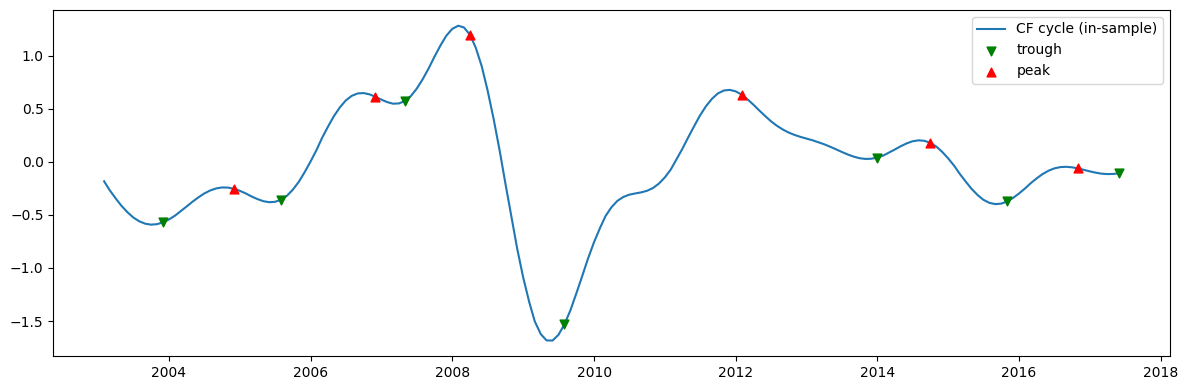

In [226]:
# === In-sample(사후) 피크/트로프 탐지: 2003-02-01 ~ 2017-06-01 ===
# 전제: df2, df2_train, detect_extrema_rule2 가 이미 정의되어 있음
# 주성분 정렬/가중치/점수 계산을 안전하게 처리

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.filters import cf_filter
import matplotlib.pyplot as plt

# 1) 정렬된 PCA 유틸: 대칭 공분산 → eigh → 내림차순 정렬
def pca_ordered(x_df, k=3):
    scaler = StandardScaler()
    Xs = scaler.fit_transform(x_df)                      # (T, p)
    cov = np.cov(Xs, rowvar=False)                      # (p, p), 대칭
    evals, evecs = np.linalg.eigh(cov)                  # 오름차순
    order = np.argsort(evals)[::-1]                     # 내림차순 인덱스
    evals = evals[order]
    evecs = evecs[:, order]
    evr = evals / evals.sum()

    k = min(k, evecs.shape[1])
    scores = Xs @ evecs[:, :k]                          # (T, k)
    cols = [f"PC{j+1}" for j in range(k)]
    scores_df = pd.DataFrame(scores, index=x_df.index, columns=cols)
    return {
        "scores": scores_df,    # PC1..PCk
        "evecs": evecs,         # 로딩(열이 PC 순서)
        "evals": evals,
        "evr": evr              # 길이 p
    }

# 2) In-sample: df2_train 전체로 PCA 1회 수행
p = pca_ordered(df2_train, k=3)
scores = p["scores"]
evr    = p["evr"]

# 3) GI(growth_indicator) 계산: EVR 상위 3개 가중, 합 1로 정규화
w = np.array([evr[0] if len(evr)>0 else 0.0,
              evr[1] if len(evr)>1 else 0.0,
              evr[2] if len(evr)>2 else 0.0], dtype=float)
wsum = w.sum() if w.sum() > 0 else 1.0
w = w / wsum

gi = 0.0
if "PC1" in scores: gi = gi + scores["PC1"] * w[0]
if "PC2" in scores: gi = gi + scores["PC2"] * w[1]
if "PC3" in scores: gi = gi + scores["PC3"] * w[2]
gi = gi.rename("growth_indicator")

# 4) CF 필터 적용(사후; 전 구간 한 번에)
cf_series, _trend = cf_filter.cffilter(gi, low=18, high=96, drift=True)
cf_series = pd.Series(cf_series, index=gi.index, name="cf")

# 5) 2개월 확인 규칙(네가 쓴 detect_extrema_rule2 그대로 사용)
#    매개변수는 기본값(필요하면 min_gap, deadband_k, prom_k 등 조정)
reg = detect_extrema_rule2(cf_series)
events_df = reg["events_df"].copy()
# 날짜 인덱스 정리
if not events_df.empty:
    events_df.index = pd.to_datetime(events_df.index)

# 6) 연속 동일 type(peak/trough) 중복 제거
filtered = events_df[events_df["type"] != events_df["type"].shift()]

# 7) 결과 확인
print("총 검출 이벤트(사후, 원본):")
print(events_df)

print("\n연속 중복 제거 후:")
print(filtered)

# 8) 플롯
plt.figure(figsize=(12,4))
plt.plot(cf_series, label="CF cycle (in-sample)")

peak_idx   = filtered.index[filtered["type"].eq("peak")]
trough_idx = filtered.index[filtered["type"].eq("trough")]

plt.scatter(trough_idx, cf_series.reindex(trough_idx), s=40, marker="v", color="green", label="trough", zorder=3)
plt.scatter(peak_idx,   cf_series.reindex(peak_idx),   s=40, marker="^", color="red",   label="peak",   zorder=3)

plt.legend()
plt.tight_layout()
plt.show()

In [227]:
# === 9) 극점(peak/trough) 탐지된 날짜 출력 ===
print("\n[극점 탐지 결과 날짜]")
for idx, row in filtered.iterrows():
    print(f"{idx.strftime('%Y-%m-%d')} → {row['type']}")


[극점 탐지 결과 날짜]
2003-12-01 → trough
2004-12-01 → peak
2005-08-01 → trough
2006-12-01 → peak
2007-05-01 → trough
2008-04-01 → peak
2009-08-01 → trough
2012-02-01 → peak
2014-01-01 → trough
2014-10-01 → peak
2015-11-01 → trough
2016-11-01 → peak
2017-06-01 → trough


In [228]:
# === 10) CF의 0 교차점(음→양, 양→음) 탐지: 3개월 미만 간격은 무시 ===
def detect_zero_crossings(series: pd.Series, min_gap_months: int = 3):
    s = series.copy()

    # 부호 시퀀스 생성
    sign = np.sign(s)
    sign = pd.Series(sign, index=s.index)
    sign = sign.replace(0, np.nan).ffill().fillna(0)

    prev = sign.shift(1)
    crossed = (sign * prev < 0)  # 부호가 바뀐 지점

    cand_idx = crossed[crossed].index

    # 3개월 미만 간격 무시 → 일 단위로 변환 (90일)
    min_gap_days = min_gap_months * 30
    kept = []
    last_kept = None
    for t in cand_idx:
        if (last_kept is None) or ((t - last_kept).days >= min_gap_days):
            kept.append(t)
            last_kept = t

    # 방향 라벨링
    out = []
    for t in kept:
        prev_val = s.loc[:t].iloc[-2] if len(s.loc[:t]) >= 2 else np.nan
        curr_val = s.loc[t]
        if pd.isna(prev_val) or pd.isna(curr_val):
            direction = "unknown"
        elif prev_val < 0 and curr_val > 0:
            direction = "neg→pos"
        elif prev_val > 0 and curr_val < 0:
            direction = "pos→neg"
        else:
            direction = "unknown"

        out.append({
            "date": t,
            "direction": direction,
            "cf_value": float(series.loc[t]) if t in series.index else np.nan
        })

    out_df = pd.DataFrame(out).set_index("date")
    return out_df

zero_cross_df = detect_zero_crossings(cf_series, min_gap_months=3)

print("\n[CF 0 교차점 (3개월 미만 간격 무시)]")
for idx, row in zero_cross_df.iterrows():
    print(f"{idx.strftime('%Y-%m-%d')}  {row['direction']}  cf={row['cf_value']:.4f}")


[CF 0 교차점 (3개월 미만 간격 무시)]
2006-01-01  neg→pos  cf=0.0043
2008-10-01  pos→neg  cf=-0.2056
2011-03-01  neg→pos  cf=0.0190
2015-02-01  pos→neg  cf=-0.0389


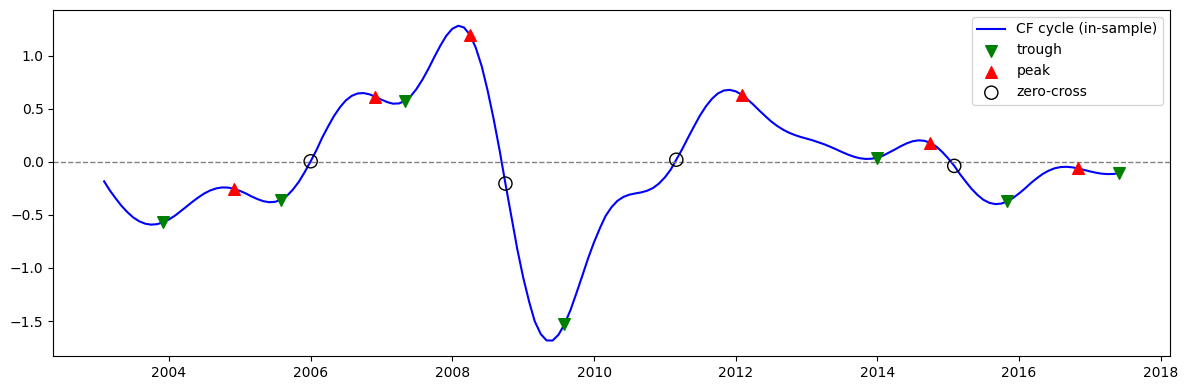

In [229]:
plt.figure(figsize=(12,4))

# CF cycle 라인
plt.plot(cf_series, label="CF cycle (in-sample)", color='blue')

# y=0 기준선
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# 극점 표시
peak_idx   = events_df.index[events_df["type"] == "peak"]
trough_idx = events_df.index[events_df["type"] == "trough"]

plt.scatter(trough_idx, cf_series.loc[trough_idx],
            s=70, marker="v", color="green", label="trough", zorder=3)
plt.scatter(peak_idx, cf_series.loc[peak_idx],
            s=70, marker="^", color="red",   label="peak",   zorder=3)

# zero-cross 표시 (필요하다면 in-sample 교차점만)
zc_idx = zero_cross_df.index.intersection(cf_series.index)
plt.scatter(zc_idx, cf_series.loc[zc_idx],
            s=90, marker='o', edgecolors='black', facecolors='none',
            label='zero-cross', zorder=4)

plt.legend()
plt.tight_layout()
plt.show()

In [230]:
# === CF 사이클을 국면으로 분류해서 기간별로 출력 ===
# 규칙
#  - 값 >= 0 이고 다음 이벤트가 peak   → 확장
#  - 값 >= 0 이고 다음 이벤트가 trough → 둔화
#  - 값 <  0 이고 다음 이벤트가 trough → 위축
#  - 값 <  0 이고 다음 이벤트가 peak   → 회복
#  - 다음 이벤트가 없으면 'unknown' (마지막 꼬리 구간)

def classify_regimes_by_next_event(cf_series: pd.Series, events_df: pd.DataFrame) -> pd.DataFrame:
    s = cf_series.copy()
    s.index = pd.to_datetime(s.index)

    ev = events_df.copy()
    ev.index = pd.to_datetime(ev.index)
    ev = ev.sort_index()
    ev = ev.loc[ev.index.intersection(s.index)]  # in-sample 범위로 제한

    # 각 시점 t에서 "다음 이벤트" 찾기
    ev_idx = ev.index.to_list()
    ev_types = ev["type"].to_list()

    def next_event_info(t):
        # t 이후 최초 이벤트
        for d, tp in zip(ev_idx, ev_types):
            if d > t:
                return d, tp
        return None, None

    # 날짜별 라벨 생성
    labels = []
    for t, val in s.items():
        nxt_date, nxt_type = next_event_info(t)
        if nxt_type is None:
            label = "unknown"
        else:
            if val >= 0 and nxt_type == "peak":
                label = "확장"
            elif val >= 0 and nxt_type == "trough":
                label = "둔화"
            elif val < 0 and nxt_type == "trough":
                label = "위축"
            elif val < 0 and nxt_type == "peak":
                label = "회복"
            else:
                label = "unknown"
        labels.append(label)

    regime_ts = pd.Series(labels, index=s.index, name="regime")

    # 연속 구간 압축
    runs = []
    if not regime_ts.empty:
        run_start = regime_ts.index[0]
        prev_label = regime_ts.iloc[0]
        for t, lab in zip(regime_ts.index[1:], regime_ts.iloc[1:]):
            if lab != prev_label:
                runs.append({"start": run_start, "end": t - pd.offsets.MonthEnd(0), "regime": prev_label})
                run_start = t
                prev_label = lab
        # 마지막 구간
        runs.append({"start": run_start, "end": regime_ts.index[-1], "regime": prev_label})

    runs_df = pd.DataFrame(runs)
    return regime_ts, runs_df

regime_ts, regime_periods = classify_regimes_by_next_event(cf_series, events_df)

# 결과 출력
print("[국면 기간 요약]")
for _, r in regime_periods.iterrows():
    print(f"{r['start'].strftime('%Y-%m-%d')} ~ {r['end'].strftime('%Y-%m-%d')}  : {r['regime']}")

# 필요하면 표로도 확인
regime_periods

[국면 기간 요약]
2003-02-01 ~ 2003-12-31  : 위축
2003-12-01 ~ 2004-12-31  : 회복
2004-12-01 ~ 2005-08-31  : 위축
2005-08-01 ~ 2006-01-31  : 회복
2006-01-01 ~ 2006-12-31  : 확장
2006-12-01 ~ 2007-05-31  : 둔화
2007-05-01 ~ 2008-04-30  : 확장
2008-04-01 ~ 2008-10-31  : 둔화
2008-10-01 ~ 2009-08-31  : 위축
2009-08-01 ~ 2011-03-31  : 회복
2011-03-01 ~ 2012-02-29  : 확장
2012-02-01 ~ 2014-01-31  : 둔화
2014-01-01 ~ 2014-10-31  : 확장
2014-10-01 ~ 2015-02-28  : 둔화
2015-02-01 ~ 2015-11-30  : 위축
2015-11-01 ~ 2016-11-30  : 회복
2016-11-01 ~ 2017-06-30  : 위축
2017-06-01 ~ 2017-06-01  : unknown


,start,end,regime
0,2003-02-01,2003-12-31,위축
1,2003-12-01,2004-12-31,회복
2,2004-12-01,2005-08-31,위축
3,2005-08-01,2006-01-31,회복
4,2006-01-01,2006-12-31,확장
5,2006-12-01,2007-05-31,둔화
6,2007-05-01,2008-04-30,확장
7,2008-04-01,2008-10-31,둔화
8,2008-10-01,2009-08-31,위축
9,2009-08-01,2011-03-31,회복
